# Introduction and Motivation

This work arose out of the need to compute the Bethe-Salpeter equation (BSE) for input vertex functions represented by quantics tensor trains (QTTs).
Existing implementations, for example in `ITensors.jl`, struggle with high bond dimensions $D$, with the important contraction operation becoming inefficient at around $D \gtrsim 150$.
To adress this and simultaneously enable parallelization, we introduce adaptive patching, replacing the monolithic tensor train by a composite made up of a collection of tensor trains, each with a smaller bond dimension and covering a subdomain.
Because the Bethe-Salpeter equation from a computational point of view consists of a series of matrix multiplications (which are equivalent to tensor train contractions), the work done here has a broad field of potential applications.

## Bethe-Salpeter equation

An essential formalism in many-body physics, the Bethe-Salpeter equation (BSE) relates the full vertex $F^r$, the bare susceptibility ${X^0}^r$ and the channel-irreducible vertex $\Gamma^r$
$$
    F^r_{\nu\nu'\omega} = \Gamma^r_{\nu\nu'\omega} + \frac{1}{\beta^2}\sum_{\nu''\nu'''} F^r_{\nu\nu''\omega} {X^0}^r_{\nu''\nu'''\omega} \Gamma^r_{\nu'''\nu'\omega}.
$$
The sum term is equal to the channel-reducible vertex $\Phi^r \equiv F^r_{\nu\nu'\omega} - \Gamma^r_{\nu\nu'\omega}$.
Here, $r$ denotes one of four (density $r=d$, magnetic $r=m$, singlet $r=s$, triplet $r=t$) channels, $\nu$ and $\nu'$ fermionic Matsubara frequencies (i.e. $\nu = (2n+1)\pi/\beta$ for some integer $n$) and $\omega$ a bosonic Matsubara frequency ($\omega = 2m\pi/\beta$ for some integer $m$).
The sums are performed over all fermionic frequencies and $\beta = 1/T$ is inverse temperature.

If we chose to straightforwardly represent our quantities by sampling them in a box centered at the origin, the BSE would be easy to implement: For each bosonic frequency, two matrix-matrix multiplications would suffice ($X^0$ is diagonal in $\nu''$ and $\nu'''$, so in practice only one matrix-matrix multiplication and one elementwise multiplication are performed; but the point here is that there are matrix-matrix multiplications to do).
But, this strategy sooner rather than later hits a wall in terms of computing power and memory requirements when approaching lower temperatures, where a larger frequency box is required to yield the same accuracy target in the BSE.
Hence, people have been looking for alternative solutions for some time, resulting e.g. in the development of the sparse intermediate representation [@shinaoka2017compressing; @Li:2020eu; @Wallerberger2023].

## Quantics tensor trains

We utilize a quantics tensor train (QTT) representation [@Shinaoka2023].
A function of a single Matsubara frequency $f_\nu$ can be approximately represented by its values on a $2^R$-frequency mesh $\nu \in \{\pi/\beta, 3\pi/\beta, \ldots, (2^{R+1} - 1)\pi/\beta\}$ (in practice, the frequency box is usually centered on the origin) where $R \in \mathbb{N}$ controls the accuracy of the representation.
Each such $\nu$ can be written as
$$
    \nu = \left(\nu_1 2^R + \nu_2 2^{R-1} + \ldots + \nu_R + 1\right)\pi/\beta \equiv (\nu_1\nu_2\ldots\nu_R)_2
$$
where the $\nu_r \in \{0, 1\}$ are binary variables.
Thus $f$ can be viewed as an order-$R$ tensor,
$$
    f_\nu = f_{\nu_1\nu_2\ldots\nu_R}
$$
which then allows us to perform SVD and convert it into a tensor train (also known as matrix-product state or MPS)
$$
    f_{\nu_1\nu_2\ldots\nu_R} \approx \sum_{\alpha_1=1}^{D_1} \cdots \sum_{\alpha_{R-1}=1}^{D_{R-1}} f^{(1)}_{\nu_1,1\alpha_1} f^{(2)}_{\nu_2,\alpha_1\alpha_2} \cdots f^{(R)}_{\nu_R,\alpha_{R-1}1}. 
$$
Here, $f^{(r)}_{\nu_r,\alpha_{r-1}\alpha_{r}}$ is a $2 \times D_{r-1} \times D_r$ tensor and $D_r$ is the bond dimension between two neighboring tensors.
We call $\alpha_r$ the bond (or internal) indices, $\nu_r$ the local (or external) indices and $D = \max_r D_r$ the tensor train's bond dimension.
If it is high enough, $D \sim 2^R$, the tensor is represented exactly, but to compress the original function, we can truncate the tensor and throw away unimportant information.
We will not go into the details of how to find the tensor train representation here, but it suffices to say we employ tensor cross interpolation (TCI) [@Ritter2024] here.
This detail however is not essential, we could very well replace TCI by a different method (e.g. SVD);
a specific feature of TCI that should be mentioned is that it uses the maximum norm to adjust the truncation to a given (requested) tolerance level.

### Matrix-product operators

A very similar concept is that of an matrix-product operator (MPO)
$$
    A_\nu^{\nu'} = \sum_{\alpha_{A,1},\ldots,\alpha_{A,R}} A^{(1),\nu_1'}_{\nu_1,1\alpha_{A,1}} A^{(2),\nu_2'}_{\nu_2,\alpha_{A,1}\alpha_{A,2}}  \cdots A^{(R),\nu_R'}_{\nu_R,\alpha_{A,R}1}.
$$
Whereas an MPS consists of order 3 tensors (one external and two internal indices), an MPO comprises order 4 tensors (two external and two internal indices).
As the name implies, an MPO can be multiplied onto an MPS (or another MPO), being analogous to a matrix if MPSs are viewed as analogous to vectors:
$$
\begin{aligned}
    (A \cdot f)_{\nu_1\ldots\nu_R} &= \sum_{\nu_1',\ldots,\nu_R'} A^{(1),\nu_1'}_{\nu_1} \cdot \ldots \cdot A^{(R),\nu_R'}_{\nu_R} f^{(1)}_{\nu_1'} \cdot \ldots \cdot f^{(R)}_{\nu_R'} \\
    &= \sum_{\nu_1',\ldots,\nu_R'} \sum_{\alpha_{A,1},\ldots,\alpha_{A,R}} \sum_{\alpha_{f,1},\ldots,\alpha_{f,R}} A^{(1),\nu_1'}_{\nu_1,1\alpha_{A,1}} f^{(1)}_{\nu_1',1\alpha_{f,1}} \cdots A^{(R),\nu_R'}_{\nu_R,\alpha_{A,R}1} f^{(R)}_{\nu_R',\alpha_{f,R}1}
\end{aligned}
$$

### Multiple variables

To form the MPS of a multivariate function $f_{\nu\nu'}$, we have two choices (with $\nu = (\nu_1\nu_2\ldots\nu_R)_2$ and $\nu' = (\nu'_1\nu'_2\ldots\nu'_R)_2$):

- Interleaved representation: $2R$ tensors of dimension $2 \times D_{r-1} \times D_r$.
    $$
        f_{\nu\nu'} \approx \sum_{\alpha_1=1}^{D_1} \cdots \sum_{\alpha_{2R-1}=1}^{D_{2R-1}} f^{(1)}_{\nu_1,1\alpha_1} f^{(2)}_{\nu_1',\alpha_1\alpha_2} f^{(3)}_{\nu_2,\alpha_2\alpha_3} f^{(4)}_{\nu_2',\alpha_3\alpha_4} \cdots f^{(2R-1)}_{\nu_R,\alpha_{2R-2}\alpha_{2R-1}} f^{(2R)}_{\nu_R',\alpha_{2R-1}1}
    $$
- Fused representation: $R$ tensors of dimension $4 \times D_{r-1} \times D_r$.
    $$
        f_{\nu\nu'} \approx \sum_{\alpha_1=1}^{D_1} \cdots \sum_{\alpha_{R-1}=1}^{D_{R-1}} f^{(1)}_{(\nu_1,\nu_1'),1\alpha_1} f^{(2)}_{(\nu_2,\nu_2'),\alpha_1\alpha_2} \cdots f^{(R)}_{(\nu_R,\nu_R'),\alpha_{R-1}1}
    $$

In the following, we will work in the fused representation.

### Multiplication (contraction) of MPSs

For clarity, we will use $i$, $j$ and $k$ in this section instead of $\nu$, $\nu'$ and $\nu''$.
Given MPSs $f_{ik}$ and $g_{kj}$, contracting them yields a new MPS $h_{ij}$.
To compute
$$
    h_{ij} = \sum_k f_{ik} g_{kj},
$$
we introduce an auxiliary MPO $\hat{f}$ (called that rather than $A$ for its connection to $f$) such that
$$
    h_{ij} = \sum_{kl} \hat{f}^{kl}_{ij} g_{kl}
$$
which is given by
$$
    \hat{f}^{kl}_{ij} = \sum_{\alpha_1,\ldots,\alpha_{R_1}} \hat{f}^{(1),(k_1, l_1)}_{(i_1, j_1),1\alpha_1} \hat{f}^{(2),(k_2, l_2)}_{(i_2, j_2),\alpha_1\alpha_2} \cdots \hat{f}^{(R),(k_R, l_R)}_{(i_R, j_R),\alpha_{R-1}1}
$$
with
$$
    \hat{f}^{(r),(k_r, l_r)}_{(i_r, j_r),\alpha_{r-1}\alpha_r} = f^{(r)}_{(k_r, i_r),\alpha_{r-1}\alpha_r} \delta_{l_rj_r}.
$$
This enables us to use efficient MPO-MPS multiplication implementations.

### Adaptive patching

To compress the information we handle more efficiently, we choose a strategy of adaptive patching by setting an upper bound $D_\mathrm{max}$ to the bond dimension $D$.
For illustration, picture a function $f(x, y)$ on a square domain $[0, 1]^2$.
We generate via TCI an MPS approximating $f$ on a $R \times R$ mesh with a certain measure of precision, discarding rows/columns of its tensors such that the result is equal to $f$ to within a given tolerance.
Now, if the MPS's bond dimension exceeds $D_\mathrm{max}$, we divide the domain into 4 smaller squares (or "patches") and construct an MPS on each with $R' \times R'$ where $R' = R - 1$, reusing the exact same interpolation points as the original domain.
We repeat this process, recursively subdividing our domain until the bond dimensions of all MPSs is smaller than or equal to $D_\mathrm{max}$.

The idea here is that in this way, we resolve more finely regions of the domain where $f$'s complexity is higher and are able to limit the bond dimension in areas of lower complexity, saving memory.
Of course, on the other hand, now multiplication becomes more involved.
Although they live on the same domain, multiplier and multiplicand are in general going to consist of different patches, so when multiplying we go over both sets of patches and search for overlapping ones which can then be multiplied as usual.

# Demonstration

We would now like to demonstrate the discussed techniques.
To this end, we choose the Hubbard atom [@Hubbard1963], where exact expressions for all quantities are known [@Thunstroem:PRB18] and implemented in the package `HubbardAtoms.jl`.

A host of Julia packages is necessary:

In [1]:
import QuanticsGrids as QG     
# utilities for handling quantics representations
import TCIAlgorithms as TCIA   
# implementation of patching
using HubbardAtoms             
# exact results for the Hubbard atom
using SparseIR                 
# provides the MatsubaraFreq types used in the HubbardAtoms package
using Quantics                 
# high-level API for performing operations in QTT
using ITensors                 
# efficient tensor computations and tensor network calculations

## Outline

The `main` function will serve to outline our approach:
- Set up the grid
- Set up the atomic vertex functions
- Interpolate the vertices into a patched QTT representation
- Add indices to prepare the MPSs for contraction
- Compute BSE
- Compare result with simple multiplication

In [1]:
function main(U, beta, ch, R, maxbonddim)
    grid, sites = setup(R)
    plainfuncs, quanticsfuncs = makeverts(U, beta, ch, grid)
    patchesfuncs = interpolateverts(quanticsfuncs, grid, maxbonddim, sites)
    pttfuncs, diagonal_sites = makevertsdiagonal(patchesfuncs, sites)
    phi_bse = calculatebse(pttfuncs, diagonal_sites, maxbonddim, sites)
    error = comparereference(phi_bse, plainfuncs, grid)
    return error
end;

In the function `setup` use `QuanticsGrids.jl` to create a grid in the shape of a $R \times R \times R$ cube almost centered on the origin of "fermionic × fermionic × bosonic" Matsubara frequency space.
"Almost", because by construction the grid consists of an even number of points ($2^R$) in each direction and bosonic Matsubara frequencies are even, so a grid centered on the origin would include an odd number of frequencies.
This is something that will not affect our calculations in this example however, because we never sum over the bosonic axis.
If we wanted to do that -- e.g. in implementing the Schwinger-Dyson equation -- special care would need to be taken.

Later, interoperation between `TCIAlgorithms.jl` and `ITensors.jl` will be necessary, so we prepare the relevant `ITensors.Index` objects.
Zipping the axes' indices together corresponds to creating the indices in the fused representation introduced above.

In [2]:
function setup(R=4)
    N = 2^R
    grid = QG.InherentDiscreteGrid{3}(R, (-N + 1, -N + 1, -N);
        step=2, unfoldingscheme=:fused)

    sitesv = [Index(2, "v=$r") for r in 1:R]
    sitesv´ = [Index(2, "v´=$r") for r in 1:R]
    sitesw = [Index(2, "w=$r") for r in 1:R]
    sitesfused = collect.(zip(sitesv, sitesv´, sitesw))
    sites = (; sitesv, sitesv´, sitesw, sitesfused)

    return grid, sites
end;

We define `makeverts`, which uses `HubbardAtoms.jl` to introduce the exact vertex functions $F$, $X^0$ and $\Gamma$ and wrap them with `QuanticsGrids.quanticsfunction` to take a list of binary indices as input instead of the plain Matsubara frequencies.
Here, we also absorb the factor of $1 / \beta^2$ that appears in the BSE into the bare susceptibility for later convenience.

In [3]:
function makeverts(U, beta, ch, grid)
    model = HubbardAtom(U, beta)

    matsubara(v, v´, w) = (FermionicFreq(v), FermionicFreq(v´), BosonicFreq(w))

    fq_full(v, v´, w) = real(full_vertex(ch, model, matsubara(v, v´, w)))
    fq_chi0(v, v´, w) = 1 / beta^2 * real(chi0(ch, model, matsubara(v, v´, w)))
    fq_gamma(v, v´, w) = real(gamma(ch, model, matsubara(v, v´, w)))
    
    plainfuncs = (; fq_full, fq_chi0, fq_gamma)

    fI_full = QG.quanticsfunction(Float64, grid, fq_full)
    fI_chi0 = QG.quanticsfunction(Float64, grid, fq_chi0)
    fI_gamma = QG.quanticsfunction(Float64, grid, fq_gamma)
    quanticsfuncs = (; fI_full, fI_chi0, fI_gamma)

    return plainfuncs, quanticsfuncs
end;

Because we work in 3 frequency dimensions in the fused representation, the local index' dimension is $2^3 = 8$ for each tensor in the MPS, i.e. `localdims == fill(8, R) == [8, 8, …, 8]`.
Used in the function `interpolateverts`, `makeprojectable` creates a `ProjectableEvaluatorAdapter`, which represents an object that can be projected on a subset of indices.
For this purpose, it contains a `Projector` which can be thought of as restricting the function's support to a subset of its domain, giving zero elsewhere.
A worked example will clarify this idea. For illustration, let us assume quantics, i.e. the tensors represent functions:

```julia
localdims = [2, 2, 2]
#= We work in one dimension with R = 3, i.e. a sequence of 2^R = 8 points on a
   line. Thinking of the interval [0.0, 1.0], the point 0.0 would be represented
   by [1, 1, 1]; 0.25 would be [1, 2, 1] and 0.875 [2, 2, 2]. =#
sitedims = [[x] for x in localdims]
projector = TCIA.Projector([[1], [0], [0]], sitedims)
#= This projector restricts the function's domain to the first half of the
   interval, i.e. [0.0, 0.5). If we had used e.g. [[1], [2], [0]], only the
   second quarter of points would give nonzero results on evaluation. So a 0
   means no restriction. =#

simpleevaluator(x) = sum(x)
projectableevaluator = TCIA.makeprojectable(Float64, simpleevaluator, localdims)
projectedevaluator = TCIA.project(projectableevaluator, projector)

@show projectedevaluator([1, 1, 1])   # Evaluate on [1, 1, 1] = 0.0
@show projectedevaluator([2, 1, 1])   # Evaluate on [2, 1, 1] = 0.5
@show projectedevaluator([2, 2, 1])   # Evaluate on [2, 2, 1] = 0.75
```

Result:
```julia
projectedevaluator([1, 1, 1]) = 3.0
projectedevaluator([2, 1, 1]) = 0.0
projectedevaluator([2, 2, 1]) = 0.0
```
Note: As the name implies, `makeprojectable`'s result is projectable, but not yet projected.

In the next step, the so created projectable evaluators are now adaptively TCIed into patched MPSs by way of `adaptiveinterpolate` (the algorithm is sketched above) creating a `ProjContainer{ProjTensorTrain}` (which happens to share its supertype `ProjectableEvaluator` with `ProjectableEvaluatorAdapter`).
Principally this contains an array of `ProjTensorTrain`s -- each of which represents a tensor train projected onto a subregion of the domain -- that are allowed to overlap.

In [4]:
function interpolateverts(quanticsfuncs, grid, maxbonddim, sites)
    (; fI_full, fI_chi0, fI_gamma) = quanticsfuncs

    localdims = dim.(sites.sitesfused)
    projectable_full = TCIA.makeprojectable(Float64, fI_full, localdims)
    projectable_chi0 = TCIA.makeprojectable(Float64, fI_chi0, localdims)
    projectable_gamma = TCIA.makeprojectable(Float64, fI_gamma, localdims)

    initialpivots = [QG.origcoord_to_quantics(grid, 0)] # approximate center
    full_patches = TCIA.adaptiveinterpolate(projectable_full;
                                            maxbonddim, initialpivots)
    chi0_patches = TCIA.adaptiveinterpolate(projectable_chi0;
                                            maxbonddim, initialpivots)
    gamma_patches = TCIA.adaptiveinterpolate(projectable_gamma;
                                            maxbonddim, initialpivots)

    sitedims = [dim.(s) for s in sites.sitesfused]
    full_patches = reshape(full_patches, sitedims)
    chi0_patches = reshape(chi0_patches, sitedims)
    gamma_patches = reshape(gamma_patches, sitedims)

    patchesfuncs = (; full_patches, chi0_patches, gamma_patches)

    return patchesfuncs
end;

As discussed above, to contract two MPSs, the function `makevertsdiagonal` turns the first one into an MPO.
For technical reasons, This requires a couple of steps:
1. Convert `ProjContainer{ProjTensorTrain}` into `ProjMPSContainer`, essentially a `Vector{ProjMPS}`. `ProjMPS` is backed by `ITensors.MPS` which supports tensors of heterogeneous order within a single tensor train. The following steps are performed for each tensor train/patch.
2. Separate off the $\omega$ indices into their own tensors:
    $$
    \begin{aligned}
        F_{\nu\nu'\omega} =& \sum_{\alpha_1,\ldots,\alpha_{R-1}} F^{(1)}_{(\nu_1,\nu_1',\omega_1),1\alpha_1} \cdots F^{(R)}_{(\nu_R,\nu_R',\omega_R),\alpha_{R-1}1} \\
        \longrightarrow& \sum_{\alpha_1,\ldots,\alpha_{2R-1}} F^{(1)}_{(\nu_1,\nu_1'),1\alpha_1} F^{(2)}_{\omega_1,\alpha_1\alpha_2} \cdots F^{(2R-1)}_{(\nu_R,\nu_R'),\alpha_{2R-2}\alpha_{2R-1}} F^{(2R)}_{\omega_R,\alpha_{2R-1}1}
    \end{aligned}
    $$
3. Make the new "$\omega$-tensors" diagonal by adding an additional $\omega'$ index, i.e.
   $$
       F^{(r)}_{\omega_r,\alpha_{r-1}\alpha_r} \longrightarrow F^{(r)}_{(\omega_r,\omega_r'),\alpha_{r-1}\alpha_r} = F^{(r)}_{\omega_r,\alpha_{r-1}\alpha_r} \delta_{\omega_r,\omega_r'}
   $$
4. Prime external indices of $X^0$ once
   $$
       {X^0}_{\nu\omega}^{\nu'\omega'} \longrightarrow {X^0}_{\nu'\omega'}^{\nu''\omega''}
   $$
   and those of $\Gamma$ twice
   $$
       {\Gamma}_{\nu\omega}^{\nu'\omega'} \longrightarrow {\Gamma}_{\nu''\omega''}^{\nu'''\omega'''}.
   $$
5. Convert back into `ProjContainer{ProjTensorTrain}`.

In [5]:
function makevertsdiagonal(patchesfuncs, sites)
    (; full_patches, chi0_patches, gamma_patches) = patchesfuncs
    (; sitesv, sitesv´, sitesw, sitesfused) = sites

    full_mps = TCIA.ProjMPSContainer(Float64, full_patches, sitesfused)
    chi0_mps = TCIA.ProjMPSContainer(Float64, chi0_patches, sitesfused)
    gamma_mps = TCIA.ProjMPSContainer(Float64, gamma_patches, sitesfused)

    sitesvv´_vec = [[v, v´] for (v, v´) in zip(sitesv, sitesv´)]
    sitesw_vec = [[w] for w in sitesw]
    sites_separatew = [x for pair in zip(sitesvv´_vec, sitesw_vec) for x in pair]
    full_vv´_w = Quantics.rearrange_siteinds(full_mps, sites_separatew)
    chi0_vv´_w = Quantics.rearrange_siteinds(chi0_mps, sites_separatew)
    gamma_vv´_w = Quantics.rearrange_siteinds(gamma_mps, sites_separatew)

    full_vv´_ww´ = Quantics.makesitediagonal(full_vv´_w, "w")
    chi0_vv´_ww´ = Quantics.makesitediagonal(chi0_vv´_w, "w")
    gamma_vv´_ww´ = Quantics.makesitediagonal(gamma_vv´_w, "w")
    diagonal_sites = full_vv´_ww´.sites

    chi0_vv´_w´w´´ = prime(chi0_vv´_ww´)
    gamma_vv´_w´´w´´´ = prime(gamma_vv´_ww´, 2)

    full_ptt = TCIA.ProjTTContainer{Float64}(full_vv´_ww´)
    chi0_ptt = TCIA.ProjTTContainer{Float64}(chi0_vv´_w´w´´)
    gamma_ptt = TCIA.ProjTTContainer{Float64}(gamma_vv´_w´´w´´´)

    pttfuncs = (; full_ptt, chi0_ptt, gamma_ptt)

    return pttfuncs, diagonal_sites
end;

Finally, we are now ready to compute the BSE
$$
    \Phi_{\nu\omega}^{\nu'''\omega'''} = \sum_{\nu'\omega'} F_{\nu\omega}^{\nu'\omega'} \left(\sum_{\nu''\omega''} {X^0}_{\nu'\omega'}^{\nu''\omega''} \Gamma_{\nu''\omega''}^{\nu'''\omega'''} \right)
$$
in the function `calculatebse` by two applications of `adaptivematmul`, which — like `adaptiveinterpolate` — creates patches as necessary to ensure no bond dimension exceeds $D_\mathrm{max}$.
To remove the superfluous $\omega'''$ index, we again go through `ProjMPSContainer`.
First, the diagonals are extracted from the $\omega\omega'$-tensors, and then merged into the $\nu\nu'$-tensors.
The result is then converted back to `ProjContainer{ProjTensorTrain}`.

In [6]:
function calculatebse(pttfuncs, diagonal_sites, maxbonddim, sites)
    (; full_ptt, chi0_ptt, gamma_ptt) = pttfuncs
    pordering = TCIA.PatchOrdering(collect(eachindex(diagonal_sites)))

    chi0_gamma_ptt = TCIA.adaptivematmul(chi0_ptt, gamma_ptt, pordering;
                                         maxbonddim)
    phi_bse_diagonal = TCIA.adaptivematmul(full_ptt, chi0_gamma_ptt, pordering;
                                           maxbonddim)

    phi_bse_diagonal_projmps = TCIA.ProjMPSContainer(Float64, phi_bse_diagonal,
                                                     diagonal_sites)
    phi_bse_projmps_vv´_w = Quantics.extractdiagonal(phi_bse_diagonal_projmps, "w")
    phi_bse_projmps_vv´w = Quantics.rearrange_siteinds(phi_bse_projmps_vv´_w,
                                                       sites.sitesfused)
    phi_bse = TCIA.ProjTTContainer{Float64}(phi_bse_projmps_vv´w)

    return phi_bse
end;

### Test
To test our implementation, the function `comparereference` compares it against straightforward summation.
As error measure, we choose the relative maximum norm over the frequency box
$$
    \mathrm{Error} = \frac{\lVert\Phi_{\nu\nu'\omega} - \Phi^{\mathrm{ref}}_{\nu\nu'\omega} \rVert_\infty}{\lVert \Phi^{\mathrm{ref}}_{\nu\nu'\omega}\rVert_\infty}.
$$

In [91]:
function comparereference(phi_bse, plainfuncs, grid)
    N = 2^(grid.R)
    vv = range(-N + 1; step=2, length=N)
    v´v´ = range(-N + 1; step=2, length=N)
    ww = range(-N; step=2, length=N)
    box = [(v, v´, w) for v in vv, v´ in v´v´, w in ww]

    (; fq_full, fq_chi0, fq_gamma) = plainfuncs
    bse_formula(v, v´, w) = sum(fq_full(v, v´´, w) *
                                fq_chi0(v´´, v´´´, w) *
                                fq_gamma(v´´´, v´, w) for v´´ in vv, v´´´ in vv)
    phi_normalmul = map(splat(bse_formula), box)

    phi_adaptivemul = [phi_bse(QG.origcoord_to_quantics(grid, p)) for p in box]

    error = norm(phi_normalmul - phi_adaptivemul, Inf) / norm(phi_normalmul, Inf)
    return error
end;

We perform the comparison in all four spin-frequency channels at $U = 3$, $\beta = 10$ with $R = 4$ (so $(2^4)^3 = 4096$ frequency points) and $D_\mathrm{max} = 40$.

In [9]:
ch_d = DensityChannel()
ch_m = MagneticChannel()
ch_s = SingletChannel()
ch_t = TripletChannel()
channels = (ch_d, ch_m, ch_s, ch_t)

println("Channel", "\t\t\t", "Error")
for ch in channels
    error = main(3.0, 10.0, ch, 4, 40)
    println(ch, "\t", error)
end

Channel			Error
DensityChannel()	2.9723290663545913e-14
MagneticChannel()	1.1061414268852963e-14
SingletChannel()	2.3590018282960624e-14
TripletChannel()	2.384282932831692e-15


Results from our implementation are up to floating point accuracy identical to the reference.

# Scaling analysis

To see how the number of patches we create depends on $R$ and on $D_\mathrm{max}$, we set $U=1$ and $\beta = 1.3$ and `adaptiveinterpolate` the full vertex in the density channel $F^{\mathrm{d}}$.

In [10]:
using CairoMakie          # plotting library

In [28]:
function numpatches(R, maxbonddim, tolerance=1e-8)
    grid, sites = setup(R)

    U = 1.0
    beta = 1.3
    ch = DensityChannel()
    _, quanticsfuncs = makeverts(U, beta, ch, grid)

    localdims = dim.(sites.sitesfused)
    projectable_full = TCIA.makeprojectable(Float64, quanticsfuncs.fI_full,
                                            localdims)

    initialpivots = [QG.origcoord_to_quantics(grid, 0)]
    full_patches = TCIA.adaptiveinterpolate(projectable_full;
                                            maxbonddim, initialpivots, tolerance)

    sitedims = [dim.(s) for s in sites.sitesfused]
    full_patches = reshape(full_patches, sitedims)
    return length(full_patches.data)
end;

First, we fix $D_\mathrm{max} = 30$ and vary $R$ from $2$ to $10$.

<!--

In [19]:
Rs = 2:10
R_npatches = numpatches.(Rs, 30)
xlabel = L"Meshsize $R$"
ylabel = L"Number of patches in $F^{\mathrm{d}}$"
title = L"Tolerance = $10^{-8}$"
axis=(; xlabel, ylabel, yscale=log10, title)

-->

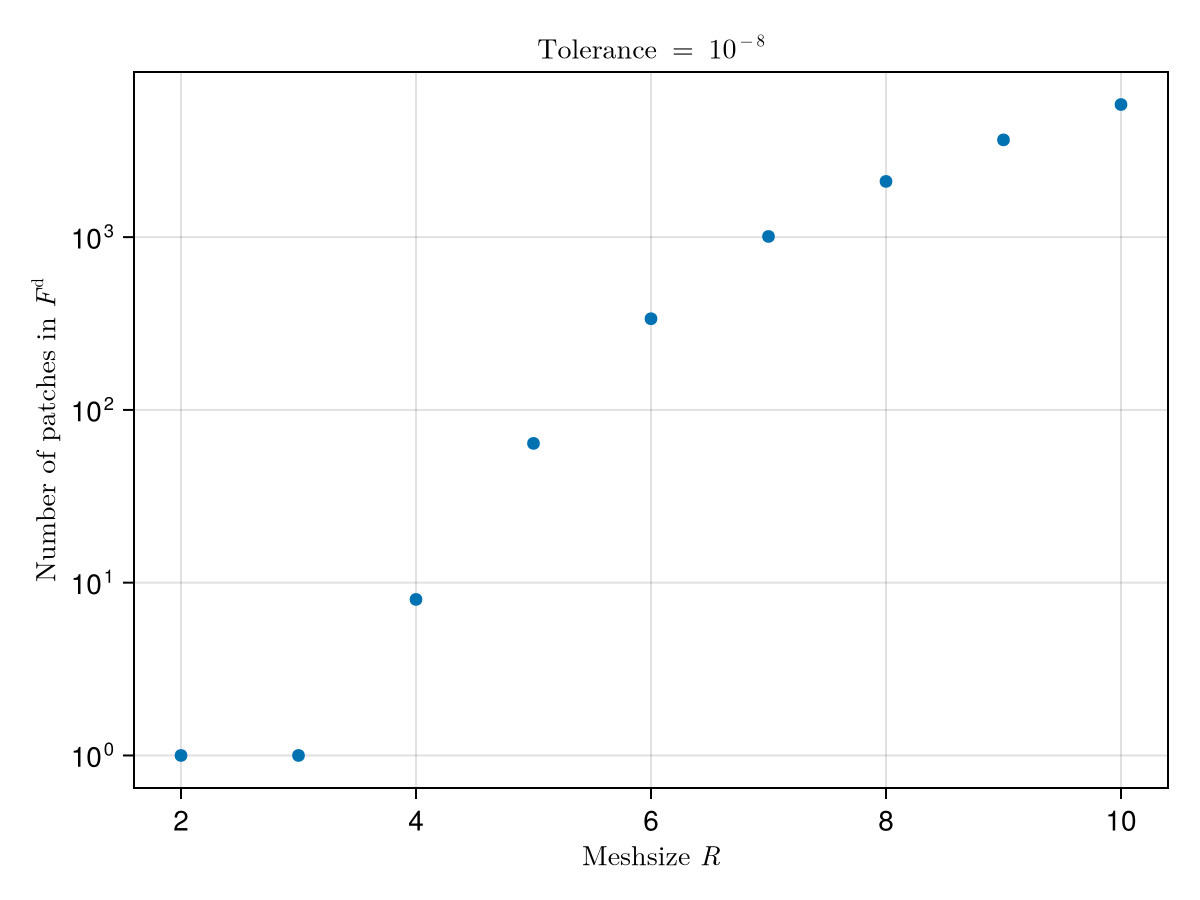

In [31]:
scatter(Rs, R_npatches; axis)

The number of patches created seems to go roughly exponentially with $R$ at the start and level off at higher values.
To try and see if it saturates eventually, we increase the tolerance used in interpolating the vertex from the default value $10^{-8}$ to $10^{-4}$, enabling us to compute higher $R$ values in a reasonable time.

<!--

In [60]:
R_hightols = 2:18
R_hightol_npatches = numpatches.(R_hightols, 30, 1e-4);
xlabel = L"Meshsize $R$"
ylabel = L"Number of patches in $F^{\mathrm{d}}$"
title = L"Tolerance = $10^{-4}$"
axis=(; xlabel, ylabel, yscale=log10, title)

-->

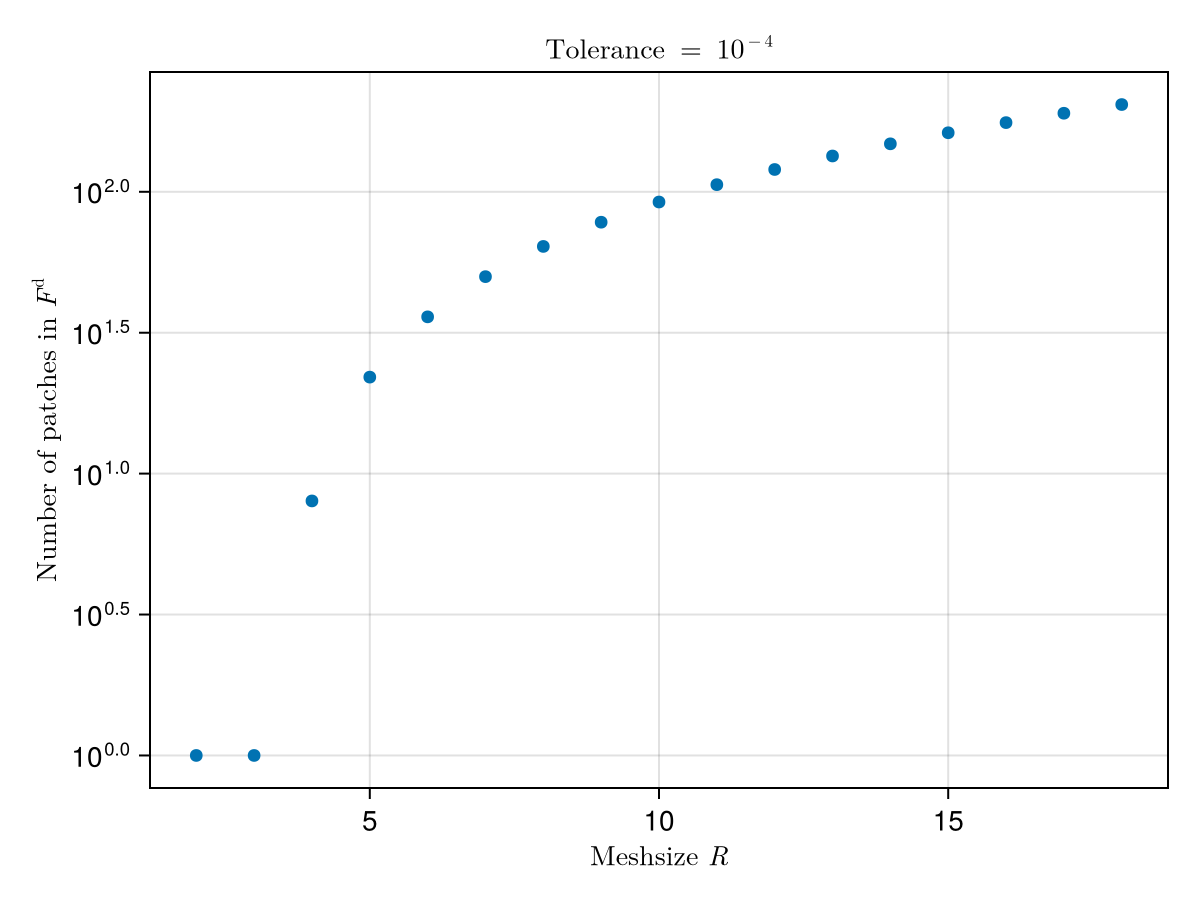

In [62]:
scatter(R_hightols, R_hightol_npatches; axis)

While not completely saturating, the growth rate of the number of patches continues to slow.

Next, we fix $R = 6$ and vary $D_\mathrm{max}$ from $10$ to $120$.

<!--

In [21]:
maxbonddims = 10:2:120
maxbonddim_npatches = numpatches.(6, maxbonddims);
xlabel = L"Max Bond Dimension $D_\mathrm{max}$"
ylabel = L"Number of patches in $F^{\mathrm{d}}$"
axis=(; xlabel, ylabel)

-->

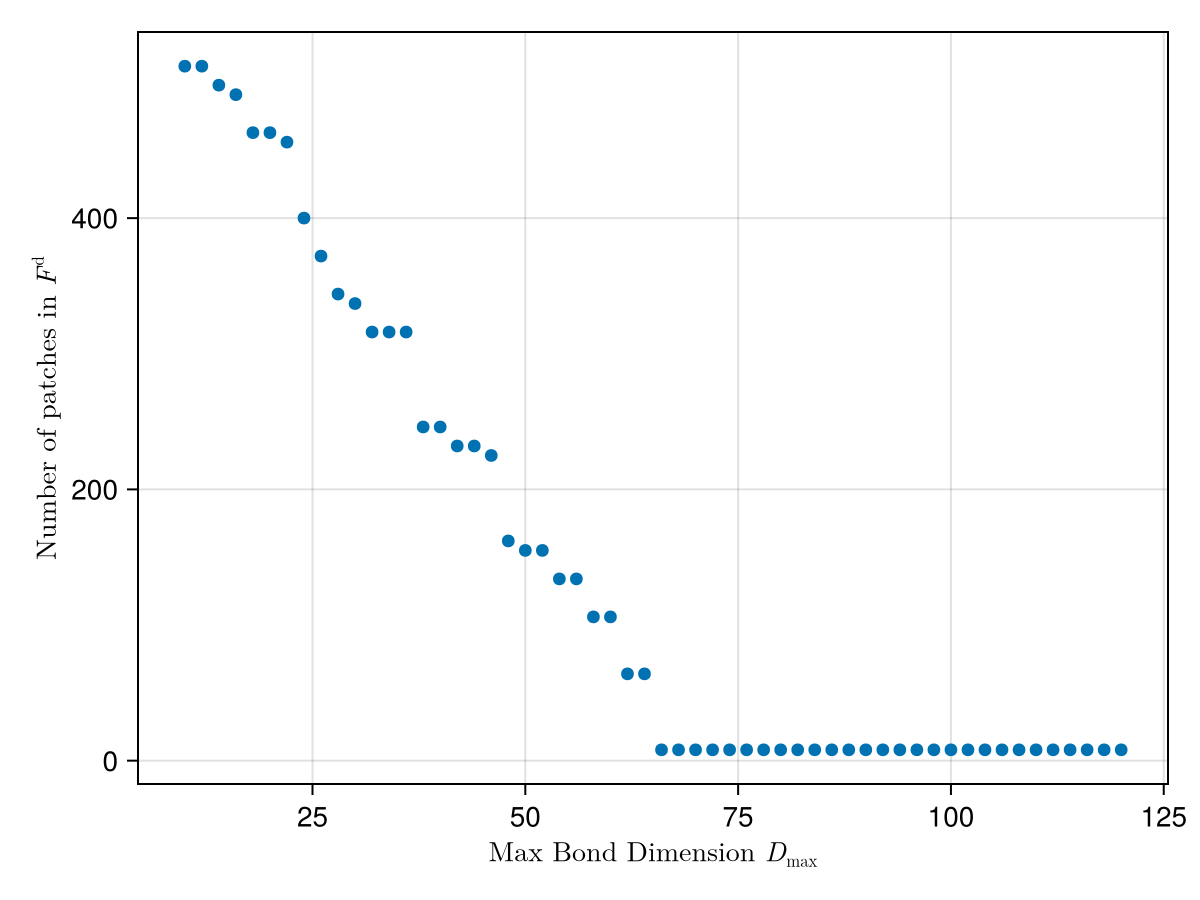

In [22]:
scatter(maxbonddims, maxbonddim_npatches; axis)

The number of patches decreases linearly with increasing bond dimension $D_\mathrm{max}$ before reaching 8 at $D_\mathrm{max} = 65$.
The bond dimension necessary to cover the entire box with a single tensor train at the requested accuracy of $10^{-8}$ is $D = 267$, so:

In [117]:
@show numpatches(6, 266) numpatches(6, 267);

numpatches(6, 266) = 8
numpatches(6, 267) = 1


# Summary and outlook

A confluence of many technological and technical developments has allowed us to create an implementation of highly efficient quantics tensor train contraction.
Crucially, to bypass problems with exceedingly large bond dimensions the QTTs are composed of multiple patches defined on subdomains.

The presented technology is but one piece in the puzzle that is a larger effort of pushing the envelope in solving the parquet equations.
There remains much to be done, including things currently being worked on: For example, the parquet equation itself requires an efficient way of applying frequency shifts to vertices in QTT form.
Once all these pieces are available, we are confident hitherto unthinkable parameter regimes will become accessible.

<!--

In [23]:
# automatic document conversion to markdown and then to pdf

run(`jupyter nbconvert --to markdown bse_3d.ipynb`)

using Base64

function extract_images(markdown_file::String)
    content = read(markdown_file, String)
    pattern = r"<img\s[^>]*src=\"data:image/[^;]+;base64,[^\"]+\"/>"

    function replace_image(sstring::SubString{String})
        m = match(r"<img\s([^>]*)src=\"(data:image/[^;]+;base64,[^\"]+)\"", sstring)
        _, base64_data = m.captures

        parts = split(base64_data, ',', limit=2)
        image_data = base64decode(strip(parts[2]))

        filepath = tempname()
        write(filepath, image_data)

        return """```{=latex}
            \\begin{center}
            ```

            ![]($filepath){ height=40% } 

            ```{=latex}
            \\end{center}
            ```"""
    end

    new_content = replace(content, pattern => replace_image)

    write(markdown_file, new_content)
end

extract_images("bse_3d.md")

function addheader(markdown_file::String)
    content = read(markdown_file, String)
    header = """
---
reference-section-title: "References"
bibliography: refs.bib
csl: american-physics-society.csl
link-citations: true
papersize: a4
---
"""
    content = header * content
    write(markdown_file, content)
end

addheader("bse_3d.md")

run(`pandoc -s bse_3d.md -t pdf -o bse_3d.pdf --citeproc --bibliography="refs.bib" --csl="american-physics-society.csl" --standalone -V geometry:margin=1.25in`)
run(`pdfunite titlepage.pdf bse_3d.pdf bse_3d_full.pdf`)

[NbConvertApp] Converting notebook bse_3d.ipynb to markdown
[NbConvertApp] Support files will be in bse_3d_files/
[NbConvertApp] Making directory bse_3d_files
[NbConvertApp] Making directory bse_3d_files
[NbConvertApp] Making directory bse_3d_files
[NbConvertApp] Writing 176028 bytes to bse_3d.md


Process(`pdfunite titlepage.pdf bse_3d.pdf bse_3d_full.pdf`, ProcessExited(0))

-->